In [2]:
import pandas as pd

# 1. Load the files
df_true = pd.read_csv('news_dataset/True.csv')
df_fake = pd.read_csv('news_dataset/Fake.csv')

# 2. Create the label column manually 
# We assign 0 for Real and 1 for Fake (this is standard for binary classification)
df_true['label'] = 0
df_fake['label'] = 1

# 3. Combine them into one single DataFrame
df = pd.concat([df_true, df_fake], axis=0)

# 4. Shuffle the data
# Important: If you don't shuffle, the model will see all '0's then all '1's, 
# which can lead to poor learning patterns.
df = df.sample(frac=1).reset_index(drop=True)

# 5. Let's see the result!
df.head()

,title,text,subject,date,label
0,Two Stunning New Polls Show These Staunch Red...,The GOP didn t panic when a poll conducted ear...,News,"May 20, 2016",1
1,Rubio And Cruz Launch Weird Anti-Trump ‘Yoga’...,The last GOP debate showed Republican presiden...,News,"March 7, 2016",1
2,LIST OF 15 CORPORATIONS Working With Obama To ...,Buckle up America Obama still has 6 months to ...,Government News,"Jul 7, 2016",1
3,"Danger of war, Germany warns after Trump's mov...",BERLIN (Reuters) - If the United States termin...,politicsNews,"October 14, 2017",0
4,Zimbabwe court postpones former finmin Chombo ...,HARARE (Reuters) - A Zimbabwean court has post...,worldnews,"December 1, 2017",0


In [3]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None

Missing values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [4]:
import re # Regular expressions for pattern matching
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Download the stopwords list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
# Initialize the Stemmer
port_stem = PorterStemmer()

def cleaning_function(content):
    # 1. Remove everything except letters (keep a-z and A-Z)
    # This replaces punctuation and numbers with a space
    cleaned_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # 2. Convert to lowercase
    cleaned_content = cleaned_content.lower()
    
    # 3. Split into individual words (Tokenization)
    cleaned_content = cleaned_content.split()
    
    # 4. Remove stopwords and Stem the remaining words
    # We use a 'list comprehension' here for speed
    cleaned_content = [port_stem.stem(word) for word in cleaned_content if not word in stopwords.words('english')]
    
    # 5. Join the words back into a single string
    cleaned_content = ' '.join(cleaned_content)
    
    return cleaned_content

In [9]:
# Let's create a new column called 'content' that combines title and author (if available)
# For this dataset, let's just use the 'title' to keep it fast for your first run
df['content'] = df['title']

# Now apply the cleaning function to the 'content' column
df['content'] = df['content'].apply(cleaning_function)

In [10]:
print("Original Title:", df['title'][0])
print("Cleaned Title:", df['content'][0])

Original Title:  Two Stunning New Polls Show These Staunch Red States Could Turn Blue To Avoid Electing Trump
Cleaned Title: two stun new poll show staunch red state could turn blue avoid elect trump


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Separate the data into X (input) and Y (output)
X = df['content'].values
Y = df['label'].values

# 2. Initialize the Vectorizer
vectorizer = TfidfVectorizer()

# 3. Fit and Transform the data
# 'Fit' learns the vocabulary; 'Transform' converts words to numbers
vectorizer.fit(X)
X = vectorizer.transform(X)

In [12]:
from sklearn.model_selection import train_test_split

# test_size=0.2 means 20% for testing, 80% for training
# stratify=Y ensures the ratio of real/fake is the same in both sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

print(f"Total data: {X.shape[0]}")
print(f"Training data: {X_train.shape[0]}")
print(f"Testing data: {X_test.shape[0]}")

Total data: 44898
Training data: 35918
Testing data: 8980


In [13]:
from sklearn.linear_model import LogisticRegression

# 1. Initialize the model
model = LogisticRegression()

# 2. Train the model using the training data
# This is where the 'learning' happens
model.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [14]:
from sklearn.metrics import accuracy_score

# 1. Accuracy on Training Data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

# 2. Accuracy on Test Data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print(f"Accuracy on Training data: {training_data_accuracy * 100:.2f}%")
print(f"Accuracy on Test data: {test_data_accuracy * 100:.2f}%")

Accuracy on Training data: 96.02%
Accuracy on Test data: 94.48%


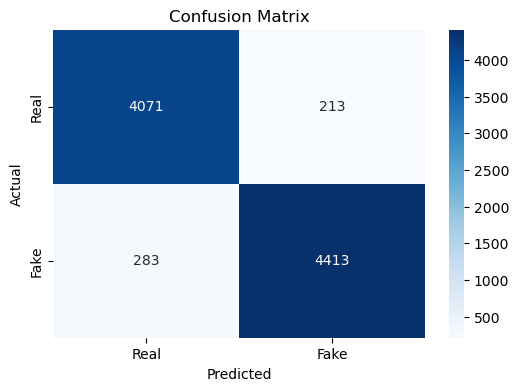

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(Y_test, X_test_prediction)

# Plotting it nicely
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
def predictive_system(news_headline):
    # 1. Clean the input text
    cleaned_news = cleaning_function(news_headline)
    
    # 2. Convert to a list (the vectorizer expects a list/array)
    input_data = [cleaned_news]
    
    # 3. Vectorize (Use .transform, NOT .fit_transform)
    vectorized_input = vectorizer.transform(input_data)
    
    # 4. Predict
    prediction = model.predict(vectorized_input)
    
    if prediction[0] == 0:
        return "The news is REAL"
    else:
        return "The news is FAKE"

# --- TEST IT HERE ---
my_news = "NASA discovers a new planet made entirely of diamonds"
print(predictive_system(my_news))

The news is FAKE


In [17]:
import pickle

# Save the Model
# 'wb' stands for 'Write Binary'
with open('fake_news_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the Vectorizer 
# We MUST save this because it contains the 20,000+ word vocabulary the model learned
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Model and Vectorizer saved successfully as .pkl files!")

Model and Vectorizer saved successfully as .pkl files!
